Implementation of models of complex networks.

Implement generators of complex networks for, at least, two of the following models of complex networks (sorted by increasing difficulty), which must include at least one of the two last ones (BA or CM):

- Erdös-Rényi (ER) networks, either G(N,K) or G(N,p)
- Watts-Strogatz (WS) small-world model
- Barabási & Albert (BA) preferential attachment model
- Configuration Model (CM) 

The correction, the number and the difficulty of the implemented models will be taken into account.

It is not allowed to use already implemented network generators such as the ones in NetworkX or Pajek. You may use libraries implementing “network” or “graph” data types, to avoid unnecessary work, but not the algorithms for the generation of networks for these models.

The delivery must include:

- Source code
- Networks generated for the selected models, with different sizes N (e.g. N=50, 100, 1000) and for different values of the parameters of the models: ER: different values of "K" for G(N,K), or of "p" for G(N,p), such that \<k> = 3, 6, 10
    
- WS: different values of "p", including p=0, e.g., p=0.0, 0.1, 0.2, 0.5, 0.9, 1.0,
- BA: different values of "m" (number of edges that each new nodes forms with the existing nodes), e.g. m=1, 2, 4, 10
- CM: different degree distributions: Poisson (ER), e.g. \<k> =2, 4; Power-law (SF) with different exponents, e.g. gamma = 2.2, 2.5, 3.0, 3.5
    
It is not necessary to generate networks for all the combinations of the parameters, e.g. for the BA you could fix N=10000 and just modify m.

It is mandatory, for each model, to generate at least one network of size N=1000 and another of N=10000.
Do not generate networks with an average degree <k> larger than 20.
    
Document (in PDF) with all the results:
- Short explanations on how have you done the required work (software, decisions, etc.)
- Plots of some of the small size generated networks, e.g. N=50 (ER, WS), N=100 (BA, CM)
- Plots of the degree distributions, including the theoretical values (corresponding to the selected parameters) and the experimental ones (for the generated network), for the networks of size N>=1000.
- Estimation of the exponent for the empirical degree distributions of BA and CM(SF), for the networks of size N>=1000.
- Do not include in the delivery (zip, rar or tgz file) the largest networks with N > 1000 nodes, their plots of degree distribution and estimation of parameters is enough.

In [1]:
import networkx as nx
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from itertools import combinations
import powerlaw
from random import randint
from scipy import stats

# Implementations of network models

## Erdös-Rényi (ER) networks

In [2]:
#Model G(N,K) by Erdős & Rényi
#K is the number of edges
#the average node degree is <k> = 2*K/N

def ER_Gnk(N,K):
    G=nx.Graph()
    G.add_nodes_from([i for i in range(N)])
    n_edges=0
    while n_edges<K:
        edge=rd.choice(list(combinations(G,2)))
        #print(edge)
        if (edge[0],edge[1]) not in G.edges():
            G.add_edge(edge[0],edge[1])
            n_edges+=1
    return G

In [3]:
#Model G(N,p) by Gilbert
# K = p*N*(N-1)/2
# <k> = p*(N-1)
def ER_Gnp(N,p):
    G = nx.Graph()
    G.add_nodes_from([i for i in range(N)])
    for u, v in combinations(G, 2):
        if rd.random() < p:
            G.add_edge(u, v)
    return G

## Watts-Strogatz (WS) model

In [4]:
def WS(N,K,p):
    G=nx.Graph()
    #construct the regular ring lattice
    G.add_nodes_from([i for i in range(N)])
    for u, v in combinations(G, 2):
        if 0 < abs(u-v)%(N-1-K/2) <= K/2:
            G.add_edge(u, v)
    #rewiring
    for v in G:
        for e in list(G.edges(v)):
            if rd.random() < p:
                #list of nodes not connected to v
                list_=[w for w in G.nodes() if w is not v and G.get_edge_data(v,w) == None]
                G.add_edge(v, rd.choice(list_)) 
                G.remove_edge(e[0],e[1])
    return G

## Barabási & Albert (BA) preferential attachment model

In [5]:
def BA(N,m,init):
    if m>init:
        print('m must be <= init')
    #create clique: fully connected graph of init nodes
    G=ER_Gnp(init,1)
    i=init
    while i <= N:
        m_count=0
        degrees=dict(G.degree)
        degrees_n=2*len(G.edges)
        G.add_node(i)
        while m_count<m:
            #select node to attach
            rdn=rd.random()*degrees_n
            bin_start=0
            for node in degrees:
                bin_start+=degrees[node]
                if rdn < bin_start:
                    if (i,node) not in G.edges:
                        G.add_edge(i,node)
                        m_count+=1
                        #print("Edge added: ({},{})".format(i, node))
                        break
        i+=1
    return G    

## Configuration Model (CM)

In [6]:
#useful functions

def fisher_yates(list): #shuffle
    len_=len(list)
    for i in range(len_-1,0,-1):
        j = randint(0,i) #0 <= j <= i
        list[i],list[j] = list[j],list[i]
    return list

def Poisson_even(N, l): 
    #generates node_degrees with poisson distribution and even sum of degrees
    node_degrees = list(np.random.poisson(l, N))
    #we need the sum of the degrees to be even to construct the edges
    if np.sum(node_degrees)%2==1:
        node_degrees[0]+=1
    node_degrees=np.array(node_degrees)
    #uncomment code below to plot the hist of the distribution
    #fig = plt.figure(figsize=(6,6))
    #plt.hist(node_degrees, bins=25, density=True, log=False);
    return node_degrees

def SF_even(N, l):
    #generates node_degrees with power-law distribution and even sum of degrees
    th=powerlaw.Power_Law(xmin=1.0, parameters = [l])
    th_gen=th.generate_random(N);
    node_degrees=list(np.floor(th_gen).astype(int))
    
    #could be done in many ways...
    #node_degrees=np.floor((1./scipy.stats.powerlaw.rvs(a=l,size=N))).astype(int)
    #powerlaw: f(x,a)=ax^(a-1), a>0, 1>=x>=0
    
    #we need the sum of the degrees to be even to construct the edges
    if np.sum(node_degrees)%2==1:
        node_degrees[0]+=1
    node_degrees=np.array(node_degrees)
    #uncomment code below to plot the hist of the distribution
    #fig = plt.figure(figsize=(6,6))
    #ax1 = fig.add_subplot()
    #ax1.set_xscale('log')
    #bins = np.logspace(np.log10(np.min(node_degrees),np.log10(np.max(node_degrees)),num=30))
    #ax1.hist(node_degrees, density=True, log=True, bins=bins);
    return node_degrees

In [7]:
def CM(node_degrees): 
    if np.sum(node_degrees)%2==1:
        print('the sum of the node degrees must be even')
        return 
    G=nx.Graph()
    G.add_nodes_from([i for i in range(len(node_degrees))])
    #construct the list of stubs
    v=[]
    for n,d in enumerate(node_degrees):
        for _ in range(d):
            v.append(n)
    #random permutation of v
    v=fisher_yates(v)
    #v=rd.shuffle(v)
    bad_edges=[]
    for i in range(0,len(v),2):
        if v[i]==v[i+1]: #avoid self-loops
            bad_edges+=[v[i],v[i+1]]
        elif (v[i],v[i+1]) in G.edges(): #avoid multi-edges
            bad_edges+=[v[i],v[i+1]]
        else:
            G.add_edge(v[i],v[i+1])
    #we reshuffle the bad_edges list to try new couples, we set a counter to stop if the 
    #remaining nodes are ineligible to form new valid edges
    counter=0
    stop=10
    #print(bad_edges)
    while len(bad_edges)!=0 and counter<stop:
        bad_edges_shuffled=fisher_yates(bad_edges)
        bad_edges=[]
        for i in range(0,len(bad_edges_shuffled),2):
            if bad_edges_shuffled[i]==bad_edges_shuffled[i+1]:
                bad_edges+=[bad_edges_shuffled[i],bad_edges_shuffled[i+1]]
            elif (bad_edges_shuffled[i],bad_edges_shuffled[i+1]) in G.edges():
                bad_edges+=[bad_edges_shuffled[i],bad_edges_shuffled[i+1]]
            else:
                G.add_edge(bad_edges_shuffled[i],bad_edges_shuffled[i+1])
            counter+=1
            #print(counter)
    #print('remaining nodes: ' , bad_edges)
    return G

I'm not sure that the implementation of CM I proposed is uniformly sampling all the networks without multi-edges or self-loops that have the desired degree distribution: repeating the permutation on the "bad edges" is increasing the probability to sample the networks that have the other edges fixed as given by the first permutation, but without multi-edges or self-loops. \
To fix this I tried to implement CM (CM_test in the cell below) restarting to build the network from scratch as soon as a not eligible edge is found, until we have a list of edges without self-loops or multi-edges. This way we are sure to sample uniformly from the networks of the desired configuration and without self-loops or multi-edges.
The problem is that unless the network is very sparse this algorithm has to generate a huge number of list of edges before finding a good one.

In [8]:
def CM_test(node_degrees): 
    G=nx.Graph()
    G.add_nodes_from([i for i in range(len(node_degrees))])
    #construct the list of stubs
    v=[]
    for n,d in enumerate(node_degrees):
        for _ in range(d):
            v.append(n)
    bad_edges=1
    while bad_edges!=0:
        #random permutation of v
        v=fisher_yates(v)
        #v=rd.shuffle(v)
        edges=[]
        for i in range(0,len(v),2):
            if v[i]==v[i+1]: #avoid self-loops
                print('self-loop')
                break
            if (v[i],v[i+1]) in edges: #avoid multi-edges
                print('multi-edge')
                break
            edges.append((v[i],v[i+1]))
            if i>=len(v)-1: 
                bad_edges=0
    G.add_edges_from(edges)
    
    return G

# Functions to estimate exponent of power-law

In [9]:
#Maximum Likelihood Estimation
def MLE(degrees):
    kmin=min(degrees)
    #print(kmin)
    summ=0
    for ki in degrees:
        summ+=np.log(ki/(kmin-1/2))
    gamma=1+len(degrees)/summ
    return gamma

def MLE_kmin(degrees, kmin):
    degrees = [d for d in degrees if d>=kmin]
    summ=0
    for ki in degrees:
        summ+=np.log(ki/(kmin-1/2))
    gamma=1+len(degrees)/summ
    return gamma

In [10]:
def linear_regression(x, y):     
    N = len(x)
    x_mean = x.mean()
    y_mean = y.mean()
    
    B1_num = ((x - x_mean) * (y - y_mean)).sum()
    B1_den = ((x - x_mean)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean - (B1*x_mean)
    
    reg_line = 'y = {} + {}x'.format(B0, round(B1, 3))
    
    return (B0, B1, reg_line)

#### Linear regression of log(P(k)) as a function of log(k)
1. Find kmin = min(k) and kmax = max(k)
2. Calculate the logarithm of ki for all the data elements
3. Divide the interval [log(kmin), log(kmax +1)] in equal size bins, e.g. 10 bins, to get de
values x0 = log(kmin), x1, x2, …, x10 = log(kmax +1)
4. Count how many elements ki have their log(ki) in each bin [x0, x1), [x1, x2), [x2, x3),…,
[x9, x10)
5. Dividing the number of elements in each bin by the total number of elements n we
get estimations for the probabilities pb of bin [xb-1, xb)
6. Make the linear regression of pairs (xb, log(pb)), to obtain the regression line of
equation y = m x + b; finally, the estimation of the exponent is gamma = -m + 1

In [11]:
def regr(degrees):
    kmin=min(degrees)
    kmax=max(degrees)
    log_degrees=np.log10(degrees)
    x=np.linspace(np.log10(kmin),np.log(kmax+1),20)
    count,_ = np.histogram(log_degrees, bins=x)
    n=sum(degrees)
    p=count/n #p[i] is the probability of bin (x[b-1],x[b])
    non_null_indexes=[b for b in range(len(p)) if p[b]>0]
    return linear_regression(x[1:][non_null_indexes],np.log10(p[non_null_indexes]))

In [12]:
def gamma_est(G):
    degrees=list(dict(G.degree()).values())
    
    mle = MLE(degrees)
    print('MLE gamma estimation, with k_min>=1: ', mle)
    
    degrees_5 = [d for d in degrees if d>5]
    mle_5 = MLE(degrees_5)
    
    print('MLE gamma estimation, with k_min>5: ', mle_5)
    
    regr_coeff=regr(degrees)[1]
    print('regr coefficient: ', regr_coeff, ', gamma =', -regr_coeff+1)

# Functions to generate plots

In [15]:
def plot_graph(name, title):
    # used for small nets: 
    # plots a view of the network and a histogram of its node degrees distribution
    degrees=list(dict(name.degree()).values())
    fig=plt.figure(figsize=(14,7))
    gs = gridspec.GridSpec(nrows=1, 
                       ncols=2, 
                       figure=fig,
                       wspace=0.1,
                          )
    ax1 = fig.add_subplot(gs[0, 0])
    plt.title(title)
    #ax1= fig.add_subplot(211)
    nx.draw(name)
    ax2= fig.add_subplot(gs[0,1])
    ax2.hist(degrees, bins=20, density=True);
    return

def plot_hist(name, title):
    #for big nets:
    # plots a histogram of its node degrees distribution in lin-lin scale
    degrees=list(dict(name.degree()).values())
    fig=plt.figure(figsize=(7,7))
    plt.title(title)
    ax1=fig.add_subplot()
    ax1.hist(degrees, bins=30, density=True);
    return

In [45]:
def plot_graph_pl(name, title):
    # used for small scale free nets: 
    # plots a view of the network and a histogram of its node degrees distribution in log-log scale

    degrees=list(dict(name.degree()).values())
    fig=plt.figure(figsize=(14,7))
    gs = gridspec.GridSpec(nrows=1, 
                       ncols=2, 
                       figure=fig,
                       wspace=0.1,
                          )
    ax1 = fig.add_subplot(gs[0, 0])
    plt.title(title)
    nx.draw(name)
    ax2= fig.add_subplot(gs[0,1])
    bins = np.logspace(np.log10(np.min(degrees)),np.log10(np.max(degrees)),num=30)
    ax2.set_xscale('log')
    ax2.hist(degrees, bins=bins, density=True, log=True);
    return

In [46]:
def plot_hist_pl(name,title):
    #for big Scale-Free nets: plots two histograms of the node degrees 
    #distribution, one in lin-lin scale and one in log-log scale

    deg=list(dict(name.degree()).values())
    fig=plt.figure(figsize=(14,7))
    plt.title(title)
    gs = gridspec.GridSpec(nrows=1, 
                       ncols=2, 
                       figure=fig,
                       wspace=0.1,
                          )
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title('lin-lin')
    ax1.hist(deg,bins=30, density=30)
    ax2= fig.add_subplot(gs[0,1])
    ax2.set_title('log-log')
    bins = np.logspace(np.log10(np.min(deg)),np.log10(np.max(deg)),num=30)
    ax2.set_xscale('log')
    ax2.hist(deg, bins=bins, density=True, log=True);
    return

# Networks

Networks generated for the selected models, with different sizes N (e.g. N=50, 100, 1000) and for different values of the parameters of the models: 
- ER: different values of "K" for G(N,K), or of "p" for G(N,p), such that \<k> = 3, 6, 10

- WS: different values of "p", including p=0, e.g., p=0.0, 0.1, 0.2, 0.5, 0.9, 1.0,
- BA: different values of "m" (number of edges that each new nodes forms with the existing nodes), e.g. m=1, 2, 4, 10
- CM: different degree distributions: Poisson (ER), e.g. \<k> =2, 4; Power-law (SF) with different exponents, e.g. gamma = 2.2, 2.5, 3.0, 3.5
    
It is not necessary to generate networks for all the combinations of the parameters, e.g. for the BA you could fix N=10000 and just modify m.

It is mandatory, for each model, to generate at least one network of size N=1000 and another of N=10000.
Do not generate networks with an average degree \<k> larger than 20.

## ER

In [18]:
N=50
avg_degree=10
K=N*(avg_degree)/2
p=2*K/(N*(N-1))
ER_p_50_10=ER_Gnp(N,p)
ER_k_50_10=ER_Gnk(N,K)
nx.write_pajek(ER_p_50_10, "Nets/ER_p_50_10")
nx.write_pajek(ER_k_50_10, "Nets/ER_k_50_10")

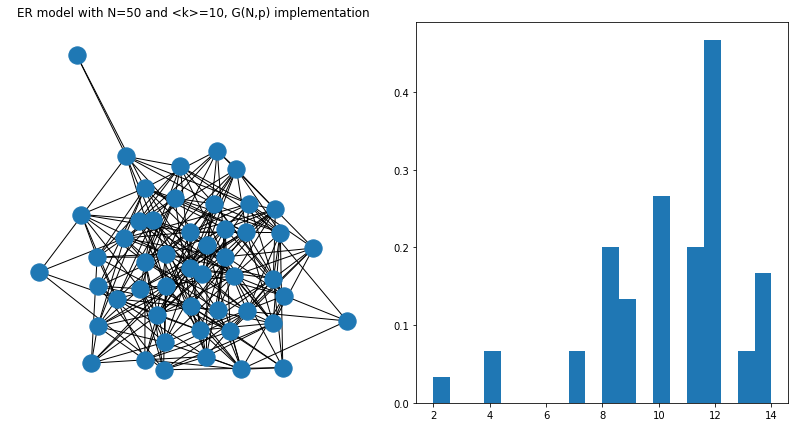

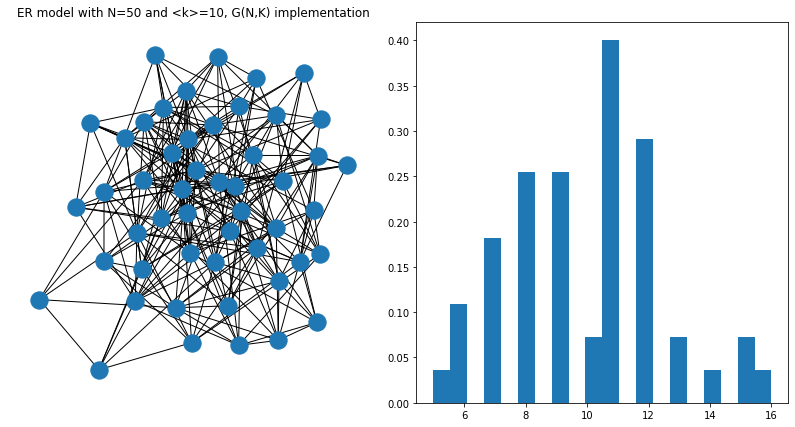

In [20]:
plot_graph(ER_p_50_10,
    'ER model with N=50 and <k>=10, G(N,p) implementation')
plt.savefig('Img/ER/ER_p_50_10.png')
plot_graph(ER_k_50_10,
    'ER model with N=50 and <k>=10, G(N,K) implementation')
plt.savefig('Img/ER/ER_k_50_10.png')

In [21]:
N=100
avg_degree=6
K=N*(avg_degree)/2
p=2*K/(N*(N-1))
ER_p_100_6=ER_Gnp(N,p)
ER_k_100_6=ER_Gnk(N,K)
nx.write_pajek(ER_p_100_6, "Nets/ER_p_100_6")
nx.write_pajek(ER_k_100_6, "Nets/ER_k_100_6")

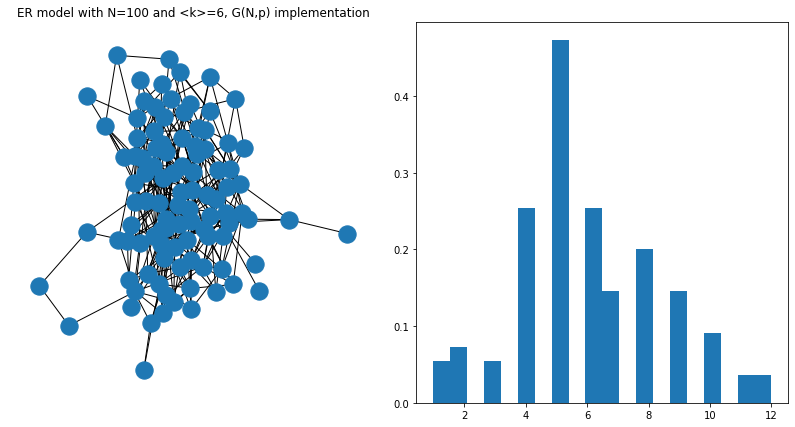

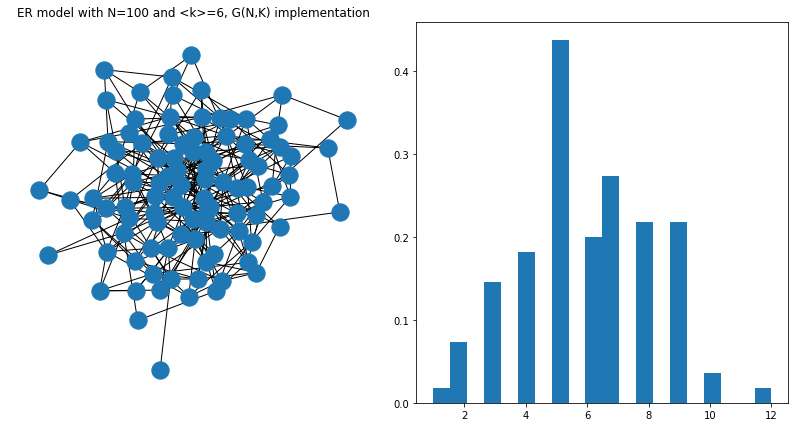

In [22]:
plot_graph(ER_p_100_6,
    'ER model with N=100 and <k>=6, G(N,p) implementation')
plt.savefig('Img/ER/ER_p_100_6.png')
plot_graph(ER_k_100_6,
    'ER model with N=100 and <k>=6, G(N,K) implementation')
plt.savefig('Img/ER/ER_k_100_6.png')

In [23]:
N=1000
avg_degree=3
K=N*(avg_degree)/2
p=2*K/(N*(N-1))
ER_p_1000_3=ER_Gnp(N,p)
#ER_k_1000_3=ER_Gnk(N,K)
nx.write_pajek(ER_p_1000_3, "Nets/ER_p_1000_3")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


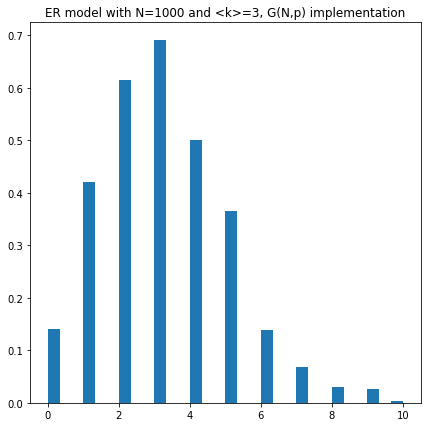

In [24]:
plot_hist(ER_p_1000_3,
          'ER model with N=1000 and <k>=3, G(N,p) implementation')
plt.savefig('Img/ER/ER_p_1000_3.png')
#plot_graph(ER_k_1000_3,
#    'ER model with N=1000 and <k>=3, G(N,K) implementation')
#plt.savefig('Img/ER/ER_k_1000_3.png')

In [107]:
N=10000
avg_degree=3
K=N*(avg_degree)/2
p=2*K/(N*(N-1))
ER_p_10000_3=ER_Gnp(N,p)
#ER_k_10000_3=ER_Gnk(N,K)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


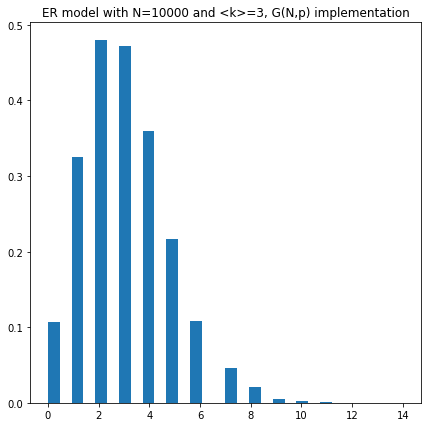

In [149]:
plot_hist(ER_p_10000_3,
    'ER model with N=10000 and <k>=3, G(N,p) implementation')
plt.savefig('Img/ER/ER_p_10000_3.png')

## WS

In [25]:
N=50
k=10 #mean degree, must be even < N
p=0.0
WS_50_10_0=WS(N,k,p)
nx.write_pajek(WS_50_10_0, "Nets/WS_50_10_0")

In [77]:
C=nx.cluster.average_clustering(WS_50_10_0)
L=nx.average_shortest_path_length(WS_50_10_0)
print('average path length and clustering: {:0.3f}, {:0.3f}'. format(L,C))

average path length and clustering: 2.959, 0.667


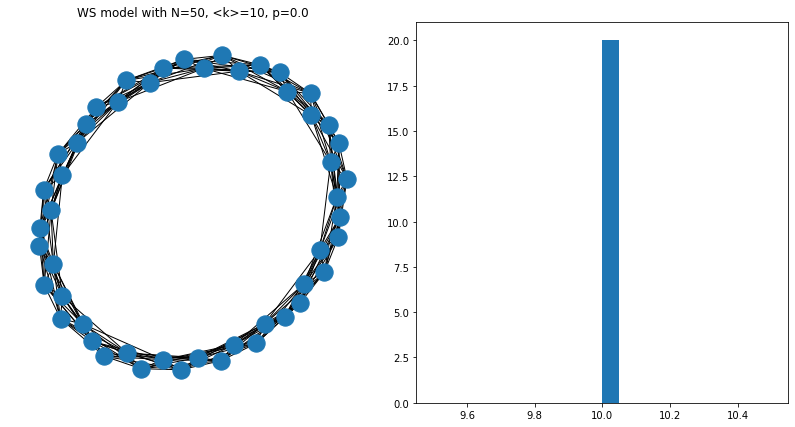

In [26]:
plot_graph(WS_50_10_0,
    'WS model with N=50, <k>=10, p=0.0')
plt.savefig('Img/WS/WS_50_10_0.png')

In [27]:
N=100
k=8 #mean degree, must be even < N
p=0.1
WS_100_8_01=WS(N,k,p)
nx.write_pajek(WS_100_8_01, "Nets/WS_100_8_01")

In [76]:
C=nx.cluster.average_clustering(WS_100_8_01)
L=nx.average_shortest_path_length(WS_100_8_01)
print('average path length and clustering: {:0.3f}, {:0.3f}'. format(L,C))

average path length and clustering: 2.819, 0.411


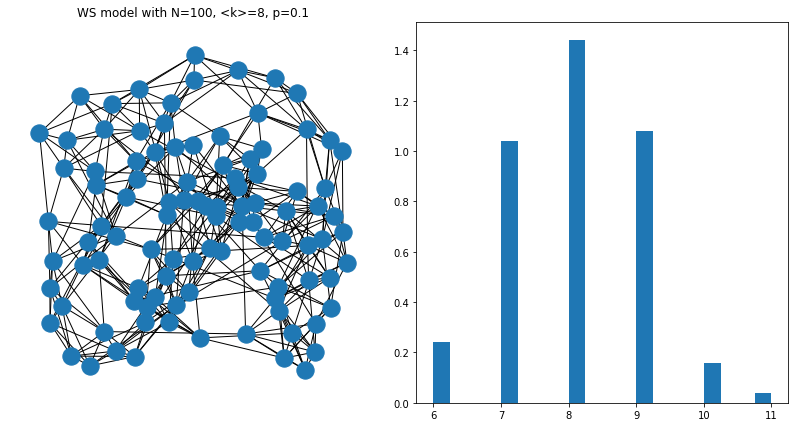

In [28]:
plot_graph(WS_100_8_01,
    'WS model with N=100, <k>=8, p=0.1')
plt.savefig('Img/WS/WS_100_8_01.png')

In [29]:
N=100
k=6 #mean degree, must be even < N
p=0.2
WS_100_6_02=WS(N,k,p)
nx.write_pajek(WS_100_6_02, "Nets/WS_100_6_02")

In [75]:
C=nx.cluster.average_clustering(WS_100_6_02)
L=nx.average_shortest_path_length(WS_100_6_02)
print('average path length and clustering: {:0.3f}, {:0.3f}'. format(L,C))

average path length and clustering: 2.870, 0.177


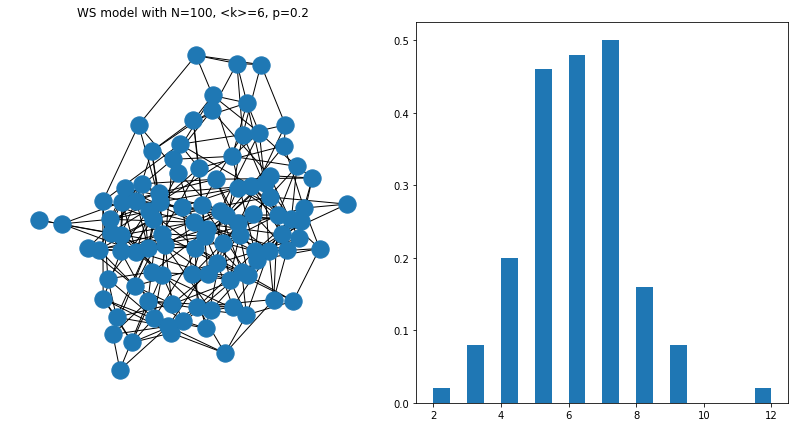

In [30]:
plot_graph(WS_100_6_02,
    'WS model with N=100, <k>=6, p=0.2')
plt.savefig('Img/WS/WS_100_6_02.png')

In [31]:
N=100
k=6 #mean degree, must be even < N
p=0.5
WS_100_6_05=WS(N,k,p)
nx.write_pajek(WS_100_6_05, "Nets/WS_100_6_05")

In [74]:
C=nx.cluster.average_clustering(WS_100_6_05)
L=nx.average_shortest_path_length(WS_100_6_05)
print('average path length and clustering: {:0.3f}, {:0.3f}'. format(L,C))

average path length and clustering: 2.741, 0.087


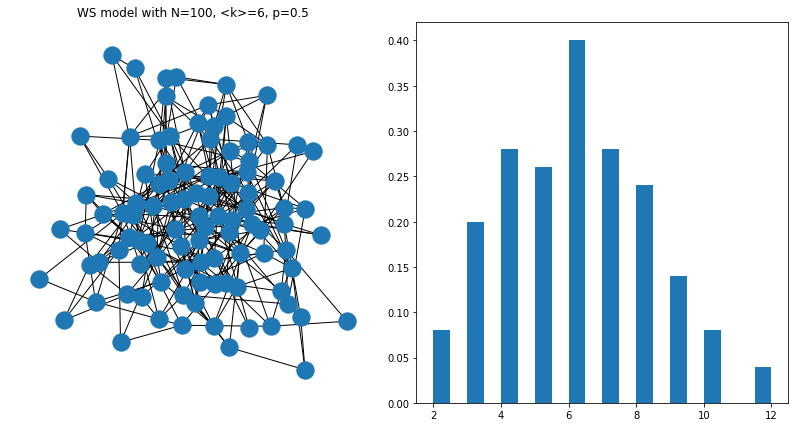

In [32]:
plot_graph(WS_100_6_05,
    'WS model with N=100, <k>=6, p=0.5')
plt.savefig('Img/WS/WS_100_6_05.png')

In [33]:
N=100
k=6 #mean degree, must be even < N
p=0.9
WS_100_6_09=WS(N,k,p)
nx.write_pajek(WS_100_6_09, "Nets/WS_100_6_09")

In [72]:
C=nx.cluster.average_clustering(WS_100_6_09)
L=nx.average_shortest_path_length(WS_100_6_09)
print('average path length and clustering: {:0.3f}, {:0.3f}'. format(L,C))


average path length and clustering: 2.759, 0.055


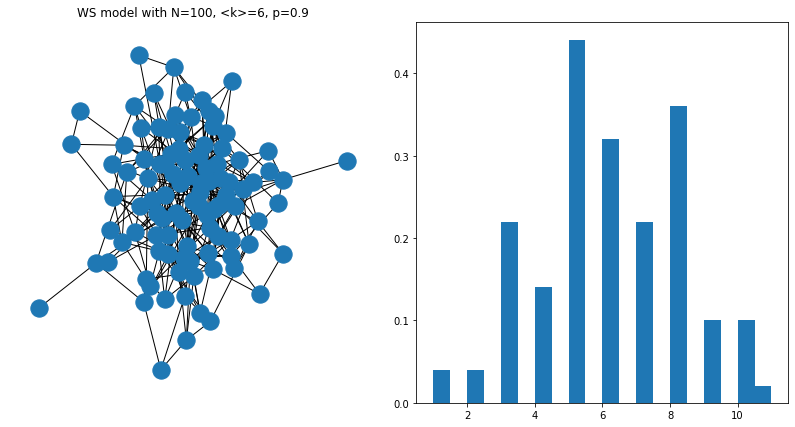

In [34]:
plot_graph(WS_100_6_09,
    'WS model with N=100, <k>=6, p=0.9')
plt.savefig('Img/WS/WS_100_6_09.png')

In [35]:
N=100
k=6 #mean degree, must be even < N
p=1
WS_100_6_1=WS(N,k,p)
nx.write_pajek(WS_100_6_1, "Nets/WS_100_6_1")

In [73]:
C=nx.cluster.average_clustering(WS_100_6_1)
L=nx.average_shortest_path_length(WS_100_6_1)
print('average path length and clustering: {:0.3f}, {:0.3f}'. format(L,C))

average path length and clustering: 2.729, 0.060


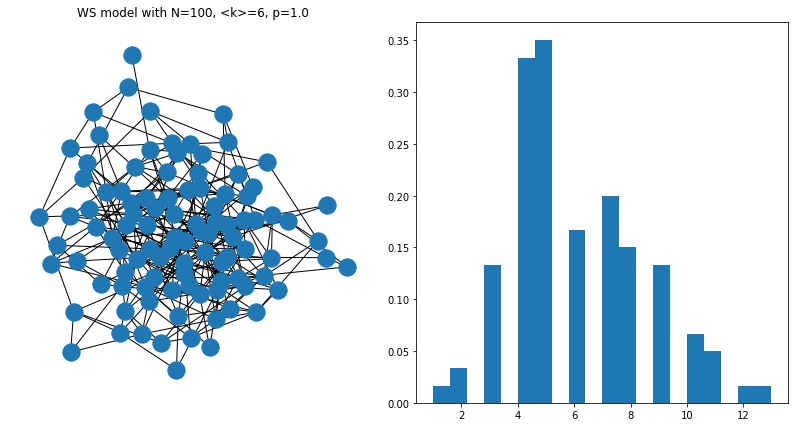

In [36]:
plot_graph(WS_100_6_1,
    'WS model with N=100, <k>=6, p=1.0')
plt.savefig('Img/WS/WS_100_6_1.png')

In [37]:
N=1000
k=4 #mean degree, must be even < N
p=0.2
WS_1000_4_02=WS(N,k,p)
nx.write_pajek(WS_1000_4_02, "Nets/WS_1000_4_02")

In [79]:
C=nx.cluster.average_clustering(WS_1000_4_02)
L=nx.average_shortest_path_length(WS_1000_4_02)
print('average path length and clustering: {:0.3f}, {:0.3f}'. format(L,C))

average path length and clustering: 5.910, 0.150


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


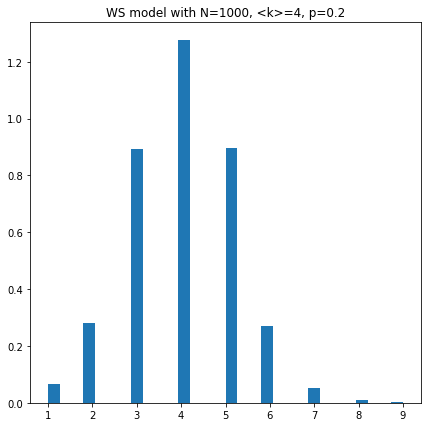

In [38]:
plot_hist(WS_1000_4_02,
    'WS model with N=1000, <k>=4, p=0.2')
plt.savefig('Img/WS/WS_1000_4_02.png')

In [41]:
N=10000
k=4 #mean degree, must be even < N
p=0.2
WS_10000_4_02=WS(N,k,p)
#nx.write_pajek(WS_10000_4_02, "Nets/WS_1000_4_02")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


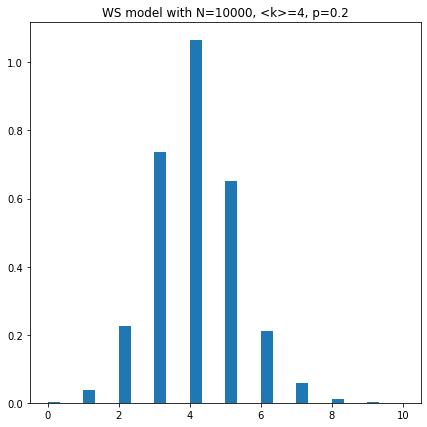

In [42]:
plot_hist(WS_10000_4_02,
    'WS model with N=10000, <k>=4, p=0.2')
plt.savefig('Img/WS/WS_10000_4_02.png')

# BA

In [47]:
N=100
m=1
init=5 #number of initial nodes
BA_100_1_5=BA(N,m,init)
nx.write_pajek(BA_100_1_5, "Nets/BA_100_1_5")

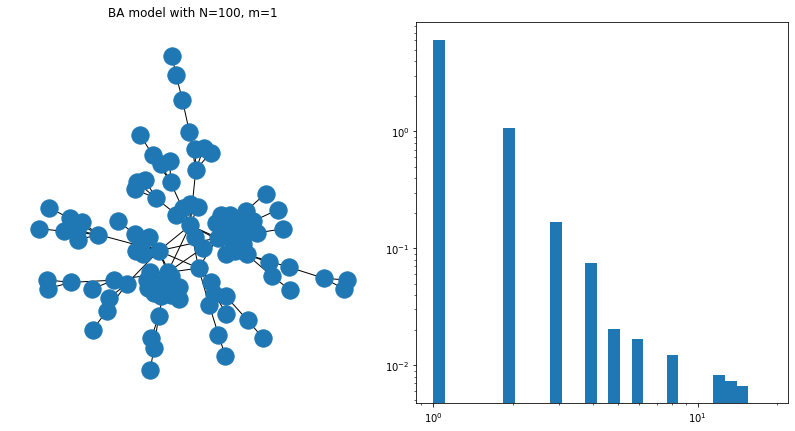

In [48]:
plot_graph_pl(BA_100_1_5, 
             'BA model with N=100, m=1')
plt.savefig('Img/BA/BA_100_1_5.png')

In [49]:
N=100
m=2
init=5 #number of initial nodes
BA_100_2_5=BA(N,m,init)
nx.write_pajek(BA_100_2_5, "Nets/BA_100_2_5")

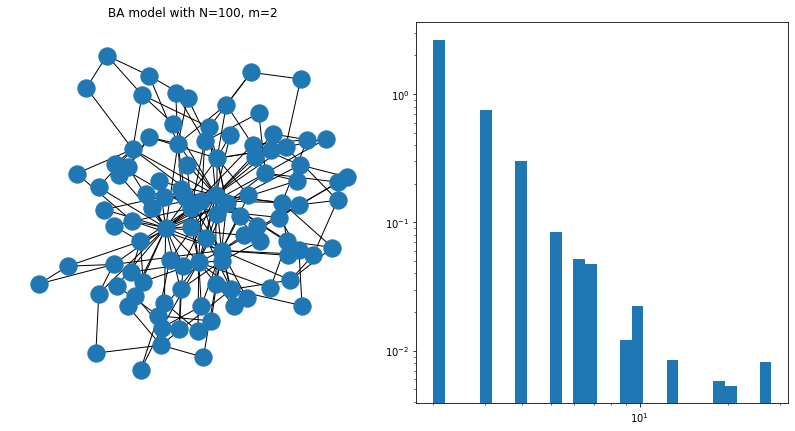

In [50]:
plot_graph_pl(BA_100_2_5, 
             'BA model with N=100, m=2')
plt.savefig('Img/BA/BA_100_2_5.png')

In [51]:
N=100
m=4
init=5 #number of initial nodes
BA_100_4_5=BA(N,m,init)
nx.write_pajek(BA_100_4_5, "Nets/BA_100_4_5")

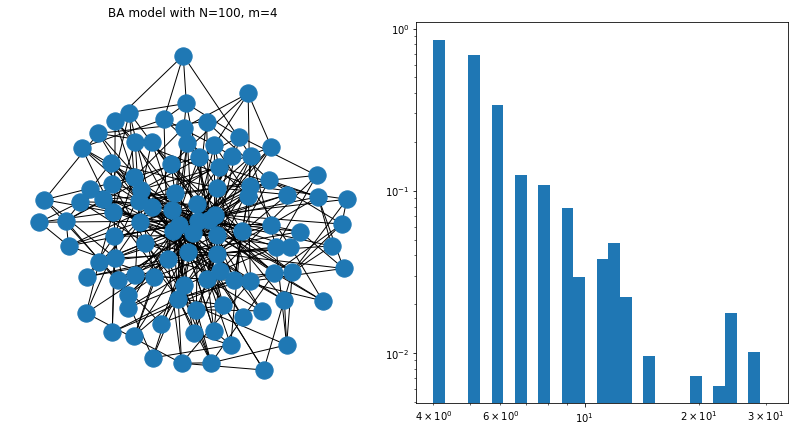

In [52]:
plot_graph_pl(BA_100_4_5, 
             'BA model with N=100, m=4')
plt.savefig('Img/BA/BA_100_4_5.png')

In [53]:
N=100
m=10
init=15 #number of initial nodes
BA_100_10_15=BA(N,m,init)
nx.write_pajek(BA_100_10_15, "Nets/BA_100_10_15")

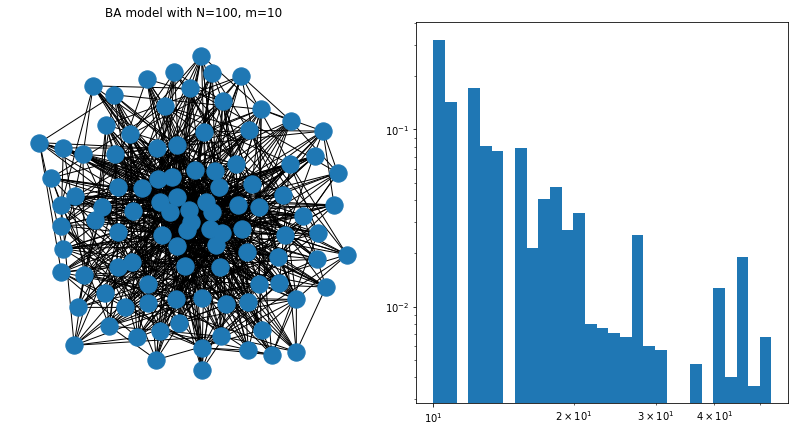

In [54]:
plot_graph_pl(BA_100_10_15, 
             'BA model with N=100, m=10')
plt.savefig('Img/BA/BA_100_10_15.png')

In [55]:
N=1000
m=10
init=15 #number of initial nodes
BA_1000_10_15=BA(N,m,init)
nx.write_pajek(BA_1000_10_15, "Nets/BA_1000_10_15")

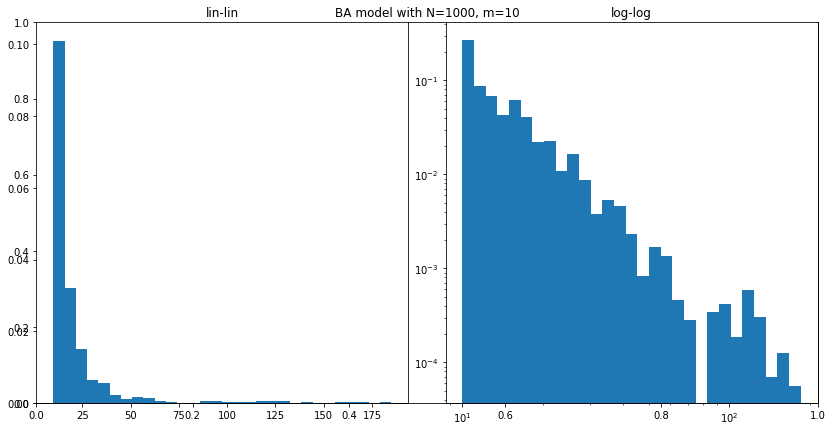

In [56]:
plot_hist_pl(BA_1000_10_15, 
          'BA model with N=1000, m=10')
plt.savefig('Img/BA/BA_1000_10_15.png')

In [57]:
gamma_est(BA_1000_10_15)

MLE gamma estimation, with k_min>=1:  2.836298844094058
MLE gamma estimation, with k_min>5:  2.836298844094058
regr coefficient:  -1.7842647789974184 , gamma = 2.7842647789974184


In [188]:
N=10000
m=1
init=5 #number of initial nodes
BA_10000_1_5=BA(N,m,init)

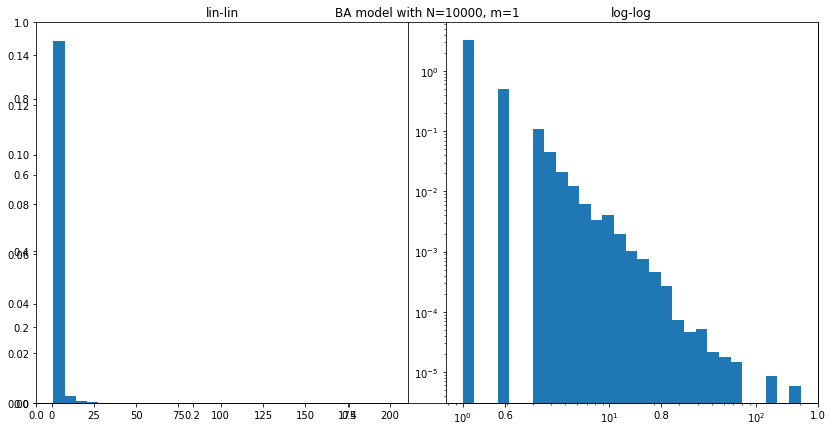

In [192]:
plot_hist_pl(BA_10000_1_5, 
          'BA model with N=10000, m=1')
plt.savefig('Nets/BA_10000_1_5.png')

In [205]:
gamma_est(BA_10000_1_5)

MLE gamma estimation, with k_min>=1:  1.9368897583500508
MLE gamma estimation, with k_min>5:  2.8270433828536565
regr coefficient:  -1.7078800986596399 , gamma = 2.70788009865964


In [193]:
N=10000
m=2
init=5 #number of initial nodes
BA_10000_2_5=BA(N,m,init)

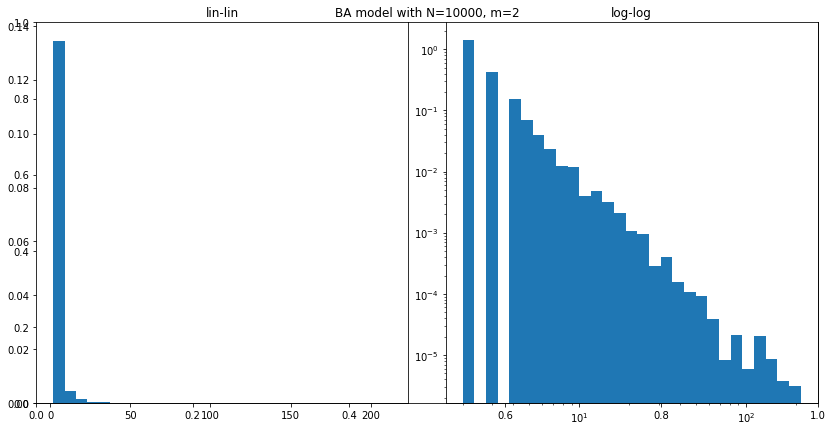

In [194]:
plot_hist_pl(BA_10000_2_5, 
          'BA model with N=10000, m=2')
plt.savefig('Img/BA/BA_10000_2_5.png')

In [204]:
gamma_est(BA_10000_2_5)

MLE gamma estimation, with k_min>=1:  2.4025401698087894
MLE gamma estimation, with k_min>5:  2.7714357582657683
regr coefficient:  -1.7699164832063694 , gamma = 2.7699164832063694


In [109]:
N=10000
m=4
init=5 #number of initial nodes
BA_10000_4_5=BA(N,m,init)

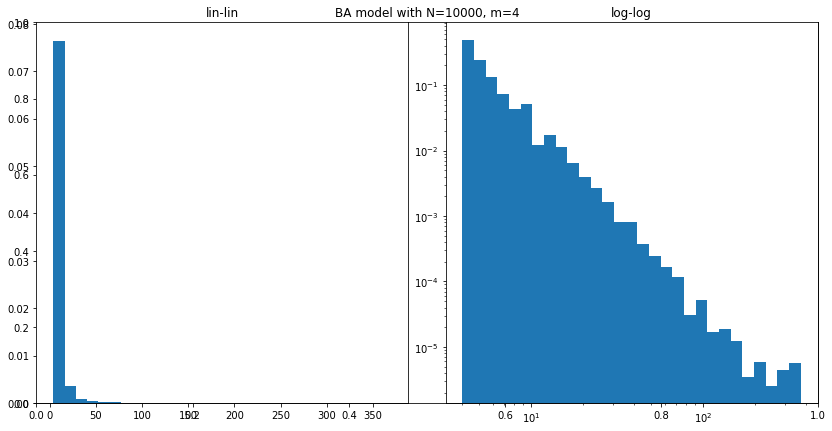

In [175]:
plot_hist_pl(BA_10000_4_5, 
          'BA model with N=10000, m=4')
plt.savefig('Img/BA/BA_10000_4_5.png')

In [203]:
gamma_est(BA_10000_4_5)

MLE gamma estimation, with k_min>=1:  2.6800070890958025
MLE gamma estimation, with k_min>5:  2.7868774574467645
regr coefficient:  -1.9057382822075657 , gamma = 2.9057382822075657


In [195]:
N=10000
m=10
init=15 #number of initial nodes
BA_10000_10_15=BA(N,m,init)

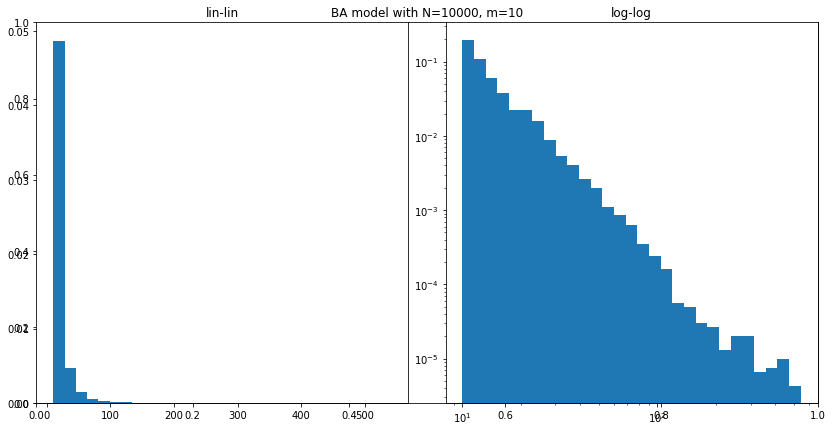

In [196]:
plot_hist_pl(BA_10000_10_15, 
          'BA model with N=10000, m=10')
plt.savefig('Img/BA/BA_10000_10_15.png')

In [202]:
gamma_est(BA_10000_10_15)

MLE gamma estimation, with k_min>=1:  2.8615367827583693
MLE gamma estimation, with k_min>5:  2.8615367827583693
regr coefficient:  -1.862050851287611 , gamma = 2.862050851287611


## CM Poisson

In [58]:
N=100
avg_degree=2
poisson_degrees=Poisson_even(N, avg_degree)
CM_Poisson_100_2=CM(poisson_degrees)
nx.write_pajek(CM_Poisson_100_2, "Nets/CM_Poisson_100_2")

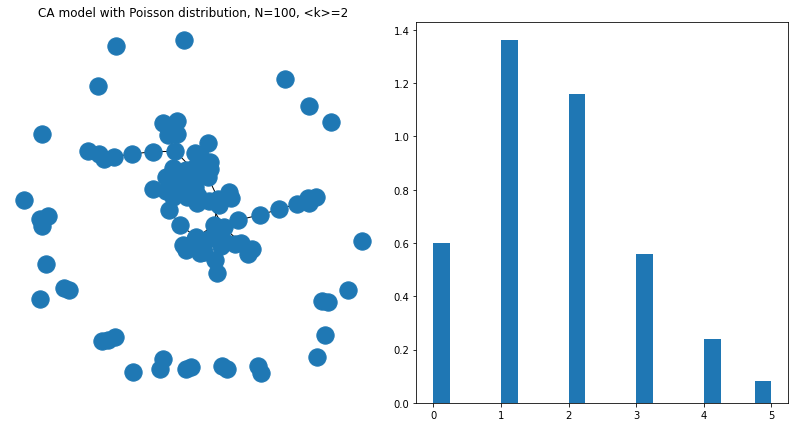

In [59]:
plot_graph(CM_Poisson_100_2,
          'CA model with Poisson distribution, N=100, <k>=2')
plt.savefig('Img/CM/CM_Poisson_100_2')

In [60]:
N=1000
avg_degree=4
poisson_degrees=Poisson_even(N, avg_degree)
CM_Poisson_1000_4=CM(poisson_degrees)
nx.write_pajek(CM_Poisson_1000_4, "Nets/CM_Poisson_1000_4")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


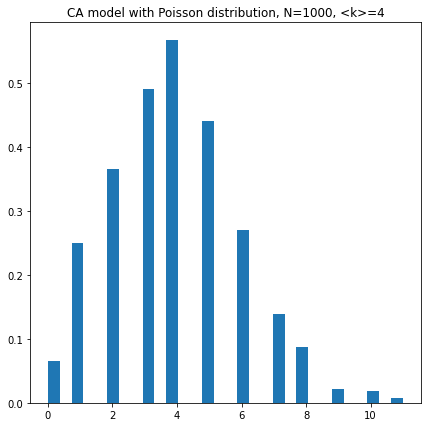

In [61]:
plot_hist(CM_Poisson_1000_4,
          'CA model with Poisson distribution, N=1000, <k>=4')
plt.savefig('Img/CM/CM_Poisson_1000_4')

In [227]:
N=10000
avg_degree=4
poisson_degrees=Poisson_even(N, avg_degree)
CM_Poisson_10000_4=CM(poisson_degrees)
nx.write_pajek(CM_Poisson_10000_4, "Nets/CM_Poisson_10000_4")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


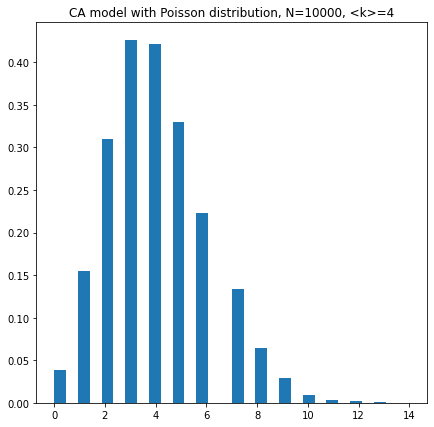

In [228]:
plot_hist(CM_Poisson_10000_4,
          'CA model with Poisson distribution, N=10000, <k>=4')
plt.savefig('Img/CM/CM_Poisson_10000_4')

## CM Scale Free

In [62]:
N=100
gamma=2
node_degrees=SF_even(N, gamma)
CM_SF_100_2=CM(node_degrees)
nx.write_pajek(CM_SF_100_2, "Nets/CM_SF_100_2")

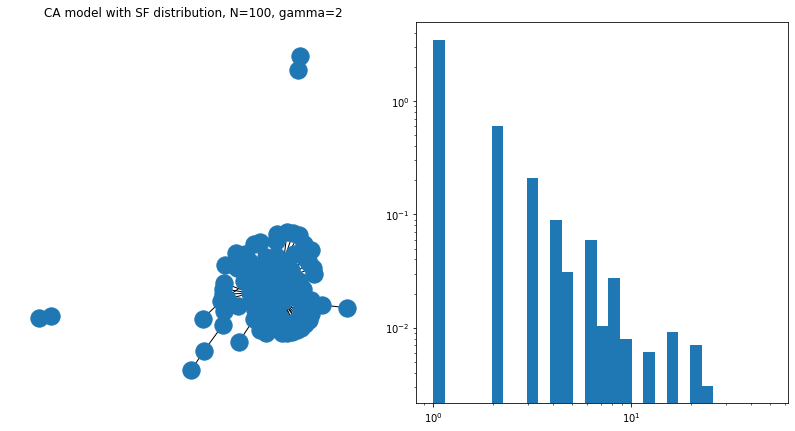

In [63]:
plot_graph_pl(CM_SF_100_2,
          'CA model with SF distribution, N=100, gamma=2')
plt.savefig('Img/CM/CM_SF_100_2')

In [64]:
print('real gamma: ', gamma)
gamma_est(CM_SF_100_2)

real gamma:  2
MLE gamma estimation, with k_min>=1:  1.7043340342377458
MLE gamma estimation, with k_min>5:  2.4332333155144843
regr coefficient:  -0.9379104045259127 , gamma = 1.9379104045259128


In [68]:
N=1000
gamma=2.2
node_degrees=SF_even(N, gamma)
CM_SF_1000_22=CM(node_degrees)
nx.write_pajek(CM_SF_1000_22, "Nets/CM_SF_1000_22")

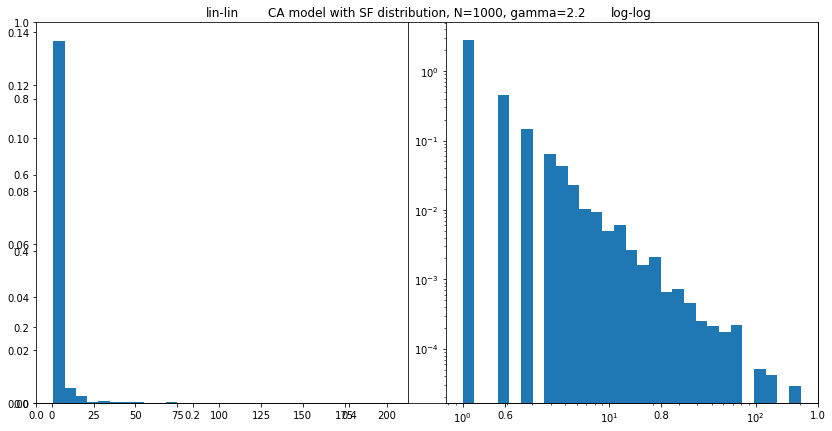

In [69]:
plot_hist_pl(CM_SF_1000_22,
          'CA model with SF distribution, N=1000, gamma=2.2')
plt.savefig('Img/CM/CM_SF_1000_22')

In [70]:
print('real gamma: ', gamma)
gamma_est(CM_SF_1000_22)

real gamma:  2.2
MLE gamma estimation, with k_min>=1:  1.768190533943788
MLE gamma estimation, with k_min>5:  2.184985934561395
regr coefficient:  -1.207612375650401 , gamma = 2.2076123756504007


In [246]:
N=10000
gamma=2.5
node_degrees=SF_even(N, gamma)
CM_SF_10000_25=CM(node_degrees)
#nx.write_pajek(CM_SF_1000_22, "Nets/CM_SF_1000_22")

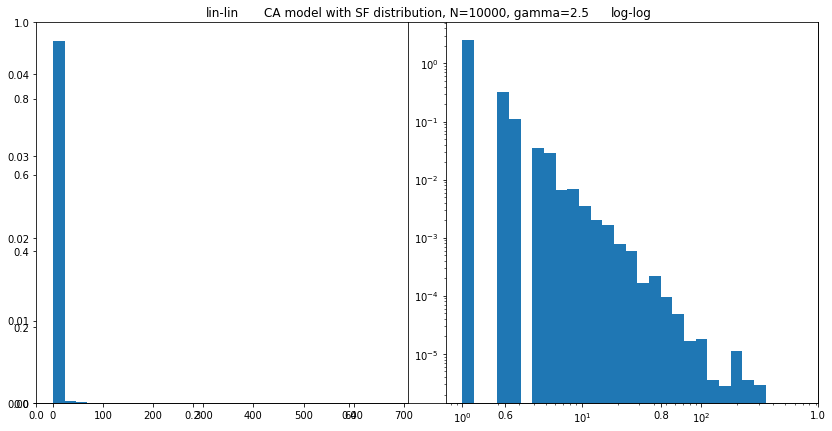

In [247]:
plot_hist_pl(CM_SF_10000_25,
          'CA model with SF distribution, N=10000, gamma=2.5')
plt.savefig('Img/CM/CM_SF_10000_25')

In [248]:
print('real gamma: ', gamma)
gamma_est(CM_SF_10000_25)

real gamma:  2.5
MLE gamma estimation, with k_min>=1:  1.8801780904348426
MLE gamma estimation, with k_min>5:  2.3335159115471353
regr coefficient:  -1.3642803749835228 , gamma = 2.364280374983523


In [249]:
N=10000
gamma=3
node_degrees=SF_even(N, gamma)
CM_SF_10000_3=CM(node_degrees)

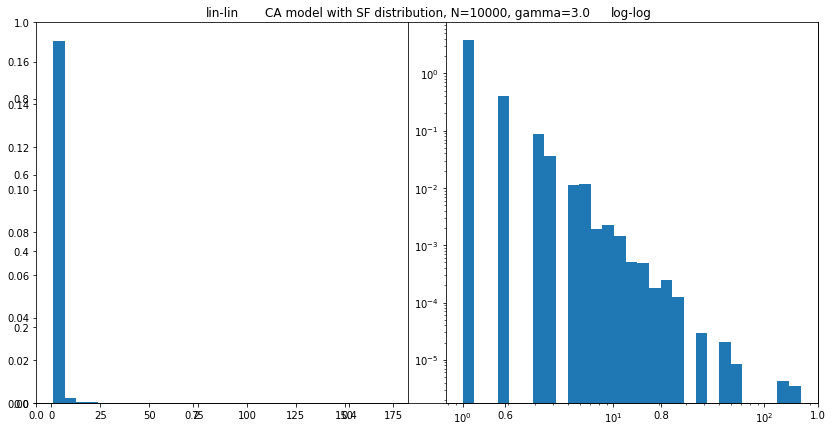

In [250]:
plot_hist_pl(CM_SF_10000_3,
          'CA model with SF distribution, N=10000, gamma=3.0')
plt.savefig('Img/CM/CM_SF_10000_3')

In [251]:
print('real gamma: ', gamma)
gamma_est(CM_SF_10000_3)

real gamma:  3
MLE gamma estimation, with k_min>=1:  2.0470731383128244
MLE gamma estimation, with k_min>5:  2.9092245003532757
regr coefficient:  -1.8808252990090109 , gamma = 2.880825299009011


In [252]:
N=10000
gamma=3.5
node_degrees=SF_even(N, gamma)
CM_SF_10000_35=CM(node_degrees)

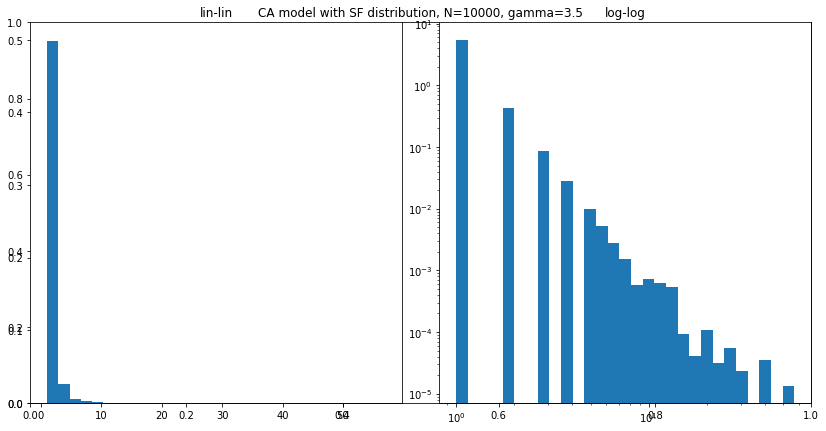

In [253]:
plot_hist_pl(CM_SF_10000_35,
          'CA model with SF distribution, N=10000, gamma=3.5')
plt.savefig('Img/CM/CM_SF_10000_35')

In [254]:
print('real gamma: ', gamma)
gamma_est(CM_SF_10000_35)

real gamma:  3.5
MLE gamma estimation, with k_min>=1:  2.15252498809289
MLE gamma estimation, with k_min>5:  3.174503921866916
regr coefficient:  -2.218783605748986 , gamma = 3.218783605748986
